In [8]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt


## Plot the support

In [ ]:
struct_L250 = np.loadtxt("runs/struct_U1.1J0.5L250.dat", skiprows=1)

In [ ]:
plt.plot(struct_L250[:, 0], struct_L250[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')

<IPython.core.display.Javascript object>


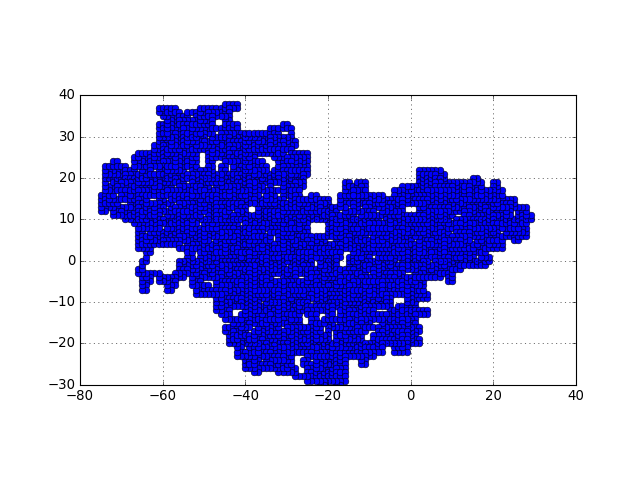

In [46]:
struct_L3600 = np.loadtxt("runs/U1.1/struct_U1.1J0.5L3600.dat", skiprows=1)

plt.plot(struct_L3600[:, 0], struct_L3600[:, 1], 'o-')
plt.grid(True)
plt.gca().set_aspect('equal')

## Ingest magnetization et al

In [5]:
# copy-pasted from ./read_replicas.py

def split_iter(lst, token):
    """Split a list on the token, yield head and tail."""
    idx  = lst.index(token)
    return lst[:idx], lst[idx+1:]


def split_list(lst, token=' -----\n'):
    res = []
    head = lst
    try:
        while True:
            head, tail = split_iter(head, token)
            res.append(head)
            head = tail
    except ValueError:
        # we're done, it seems
        pass
    return res

## test case, trivial
#lst = [1, 2, 3, -1, 4, 5, -1, 6, 7, -1, 8]
#print(split_list(lst, token=-1))

def convert_replica(lst):
    """Parse the lines for a single replica."""
    assert len(lst) == 6
    lst_s = [elem.split('!') for elem in lst]

    r = {}
    for pair in lst_s:
        assert len(pair) == 2
        names = pair[1].strip().split(',')
        values = [float(_) for _ in pair[0].split()]
        for name, val in zip(names, values):
            r[name.strip()] = val

    return r


def read_replica_file(fname, ax=None):
    with open(fname) as f:
        lines = f.readlines()

    # XXX: skip header for now
    str_replicas = split_list(lines)
    str_replicas = str_replicas[1:]

    # convert: replicas will be a list of dicts of {name: value}
    replicas = [convert_replica(str_replica) for str_replica in str_replicas]

    # compute the Binder cumulant
    m2 = np.asarray([_["av_m2"] for _ in replicas])
    err_m2 = np.asarray([_["err_m2"] for _ in replicas])

    m4 = np.asarray([_["av_m4"] for _ in replicas])
    err_m4 = np.asarray([_["err_m4"] for _ in replicas])

    Q = 1. - m4/3.0/m2**2
    err_Q = (2*err_m2 / m2)**2 + (err_m4 / m4)
    err_Q = np.sqrt(err_Q) * Q

    #print("num replicas = ", Q.size)
    #print("Binder Q = ", Q.mean(), Q.std())
    
    if ax is not None:
        plt.hist(Q)
    
    return m2, err_m2, m4, err_m4, Q, err_Q

In [35]:
# {J : Ls}
runs = {0.35 : [450, 850, 1600, 3600],
        0.42 : [450, 850, 1600, 3600, 10000],
        0.45 : [3600, 10000],
        0.47 : [10000],
        0.5 :  [450, 1600, 3600, 10000],
       }

In [36]:
dt = [('J', float), ('L', int),
      ('m2', float), ('err_m2', float), ('m4', float), ('err_m4', float), ('Q', float), ('err_Q', float)]

arrs = []
for J in runs:
    for L in runs[J]:
        fname = "runs/U1.1/replicas_U1.1J" + str(J) + "L" + str(L) + '.dat'
        m2, err_m2, m4, err_m4, Q, err_Q = read_replica_file(fname)
        arr = np.empty(1, dtype=dt)
        arr['m2'], arr['err_m2'] = m2.mean(), err_m2.mean()
        arr['m4'], arr['err_m4'] = m4.mean(), err_m4.mean()
        arr['Q'], arr['err_Q'] = Q.mean(), np.sqrt((err_Q**2).sum() / err_Q.size)    # FIXME
        arr['J'], arr['L'] = J, L
        arrs.append(arr)
        
df = pd.DataFrame(np.concatenate(arrs))
df

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
0,0.35,450,0.018985,0.000093,0.001039,1.032461e-05,0.043256,0.004360
1,0.35,850,0.010917,0.000068,0.000349,4.535033e-06,0.025262,0.002943
2,0.35,1600,0.006176,0.000050,0.000113,1.928000e-06,0.014054,0.002019
3,0.35,3600,0.002889,0.000034,0.000025,6.243053e-07,0.006824,0.001811
4,0.42,450,0.054610,0.000169,0.007617,4.254953e-05,0.159739,0.012163
5,0.42,850,0.035615,0.000128,0.003413,2.308995e-05,0.114051,0.009560
6,0.42,1600,0.022759,0.000098,0.001444,1.209903e-05,0.078322,0.007281
7,0.42,3600,0.011546,0.000067,0.000386,4.533468e-06,0.040707,0.004491
8,0.42,10000,0.004635,0.000045,0.000064,1.302315e-06,0.015804,0.002459
9,0.45,3600,0.034906,0.000130,0.003191,2.171637e-05,0.144334,0.012221


In [10]:
df[df['L']==10000]

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
4,0.42,10000,0.004635,0.000045,0.000064,0.000001,0.015804,0.002265
6,0.45,10000,0.016859,0.000092,0.000798,0.000008,0.077667,0.008013
7,0.47,10000,0.078974,0.000248,0.013133,0.000067,0.310296,0.022356
11,0.50,10000,0.507993,0.000207,0.269091,0.000179,0.653011,0.016858


<IPython.core.display.Javascript object>


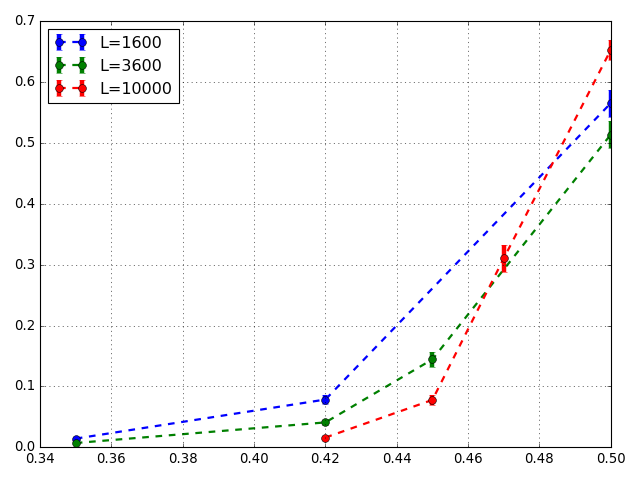

In [45]:
for L in [1600, 3600, 10000]:
    d = df[df['L']==L]
    plt.errorbar(d['J'].values, d['Q'].values, yerr=d['err_Q'].values,
                 fmt='o--', ms=7, elinewidth=4, lw=2, label='L=%s'%L)

plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

In [15]:
d

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
2,0.42,1600,0.022759,0.000098,0.001444,0.000012,0.078322,0.007165
9,0.50,1600,0.330689,0.000335,0.142245,0.000216,0.565468,0.022202


In [17]:
d['J']

2    0.42
9    0.50
Name: J, dtype: float64

In [77]:
dt = np.dtype([('a', float), ('b', float)])
d = np.ones(4, dtype=dt)

d['a'] = d['a'].cumsum()
d['b'] = 1./d['b'].cumsum()

In [78]:
d

array([(1.0, 1.0), (2.0, 0.5), (3.0, 0.3333333333333333), (4.0, 0.25)], 
      dtype=[('a', '<f8'), ('b', '<f8')])

In [43]:
pd.DataFrame(d)

,a,b
0,1.0,1.000000
1,2.0,0.500000
2,3.0,0.333333
3,4.0,0.250000


In [56]:
dd = np.hstack((d, d))

In [57]:
dd['a']

array([ 1.,  2.,  3.,  4.,  1.,  2.,  3.,  4.])

In [37]:
d['a'] = d['a'].cumsum()

In [38]:
d

array([(1.0, 1.0), (2.0, 1.0), (3.0, 1.0), (4.0, 1.0)], 
      dtype=[('a', '<f8'), ('b', '<f8')])

In [79]:
arrs

[array([ (0.42, 450, 0.054610379944043476, 0.00016892235811944489, 0.00761731425809738, 4.2549533177256166e-05, 0.15973857153921364, 0.011947098912504117)], 
       dtype=[('J', '<f8'), ('L', '<i8'), ('m2', '<f8'), ('err_m2', '<f8'), ('m4', '<f8'), ('err_m4', '<f8'), ('Q', '<f8'), ('err_Q', '<f8')]),
 array([ (0.42, 10000, 0.004635459103120434, 4.5298997408400466e-05, 6.360601814765763e-05, 1.3023148667486248e-06, 0.01580351650386085, 0.0022653086871458296)], 
       dtype=[('J', '<f8'), ('L', '<i8'), ('m2', '<f8'), ('err_m2', '<f8'), ('m4', '<f8'), ('err_m4', '<f8'), ('Q', '<f8'), ('err_Q', '<f8')]),
 array([ (0.45, 3600, 0.034905602305163735, 0.00013043989692366353, 0.003191284988138143, 2.171637068498813e-05, 0.14433390812753652, 0.01193445407802593)], 
       dtype=[('J', '<f8'), ('L', '<i8'), ('m2', '<f8'), ('err_m2', '<f8'), ('m4', '<f8'), ('err_m4', '<f8'), ('Q', '<f8'), ('err_Q', '<f8')]),
 array([ (0.45, 10000, 0.016858905130518013, 9.196811673243256e-05, 0.0007975797003034475

In [83]:
np.concatenate(arrs).dtype

dtype([('J', '<f8'), ('L', '<i8'), ('m2', '<f8'), ('err_m2', '<f8'), ('m4', '<f8'), ('err_m4', '<f8'), ('Q', '<f8'), ('err_Q', '<f8')])

In [84]:
np.concatenate(arrs).shape

(4,)

In [85]:
pd.DataFrame(np.concatenate(arrs))

,J,L,m2,err_m2,m4,err_m4,Q,err_Q
0,0.42,450,0.054610,0.000169,0.007617,0.000043,0.159739,0.011947
1,0.42,10000,0.004635,0.000045,0.000064,0.000001,0.015804,0.002265
2,0.45,3600,0.034906,0.000130,0.003191,0.000022,0.144334,0.011934
3,0.45,10000,0.016859,0.000092,0.000798,0.000008,0.077667,0.008013


Это просто текст *курсив*

$$
\Gamma^2
$$